In [1]:
import numpy as np
import networkx as nx
from qiskit import QuantumCircuit
from qiskit import visualization
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler
from scipy.optimize import minimize
from matplotlib import pyplot as plt
from itertools import combinations

In [2]:
n=4
g = nx.Graph()
g.add_nodes_from([i for i in range(1, n+1)])
edge_list = [(1,2,1), (1,3,1), (2,4,1), (3,4,1)]
g.add_weighted_edges_from(edge_list)
colors = ['c' for node in g.nodes()]
pos = nx.spring_layout(g)
def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

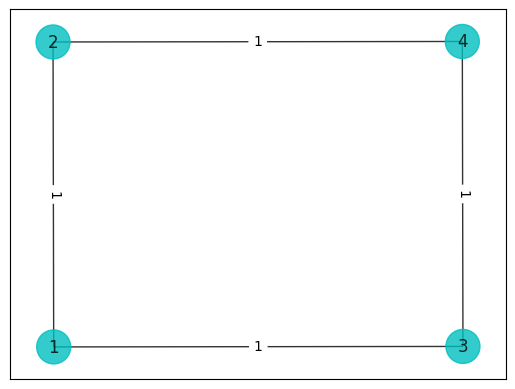

In [3]:
draw_graph(g, colors, pos)

In [4]:
def initial_state_preparation(cirq, n_qubits, n_colors):
    for q in range(n_qubits * n_colors):
        cirq.h(q)
    return cirq

In [5]:
def one_color(cirq, n_qubits, n_colors, C, gamma):
    for v in range(1, n_qubits + 1):
        indices = [(v-1) * n_colors + i for i in range(n_colors)]
        for i in indices:
            for j in indices:
                if i == j:
                    cirq.rz(2 * gamma * C, i)  # Apply RZ with phase based on the Hamiltonian coefficient
                else:
                    cirq.cx(i, j)
                    cirq.rz(2 * gamma * C, j)
                    cirq.cx(i, j)
    return cirq
    # qc1.draw('mpl')

In [6]:
def vertex_color(cirq, n_colors, edges, gamma, D ):
    for (u, v) in edges:
        for c in range(n_colors):
            idx_u = (u - 1) * n_colors + c
            idx_v = (v - 1) * n_colors + c
            cirq.cx(idx_u, idx_v)
            cirq.rz(2 * gamma * D, idx_v)  # Applying a phase dependent on the edge existence
            cirq.cx(idx_u, idx_v)
    return cirq

In [7]:
def mix_layer(cirq,n_qubits, n_color, beta):
    for q in range(n * n_colors):
        cirq.rx(2 * beta, q)

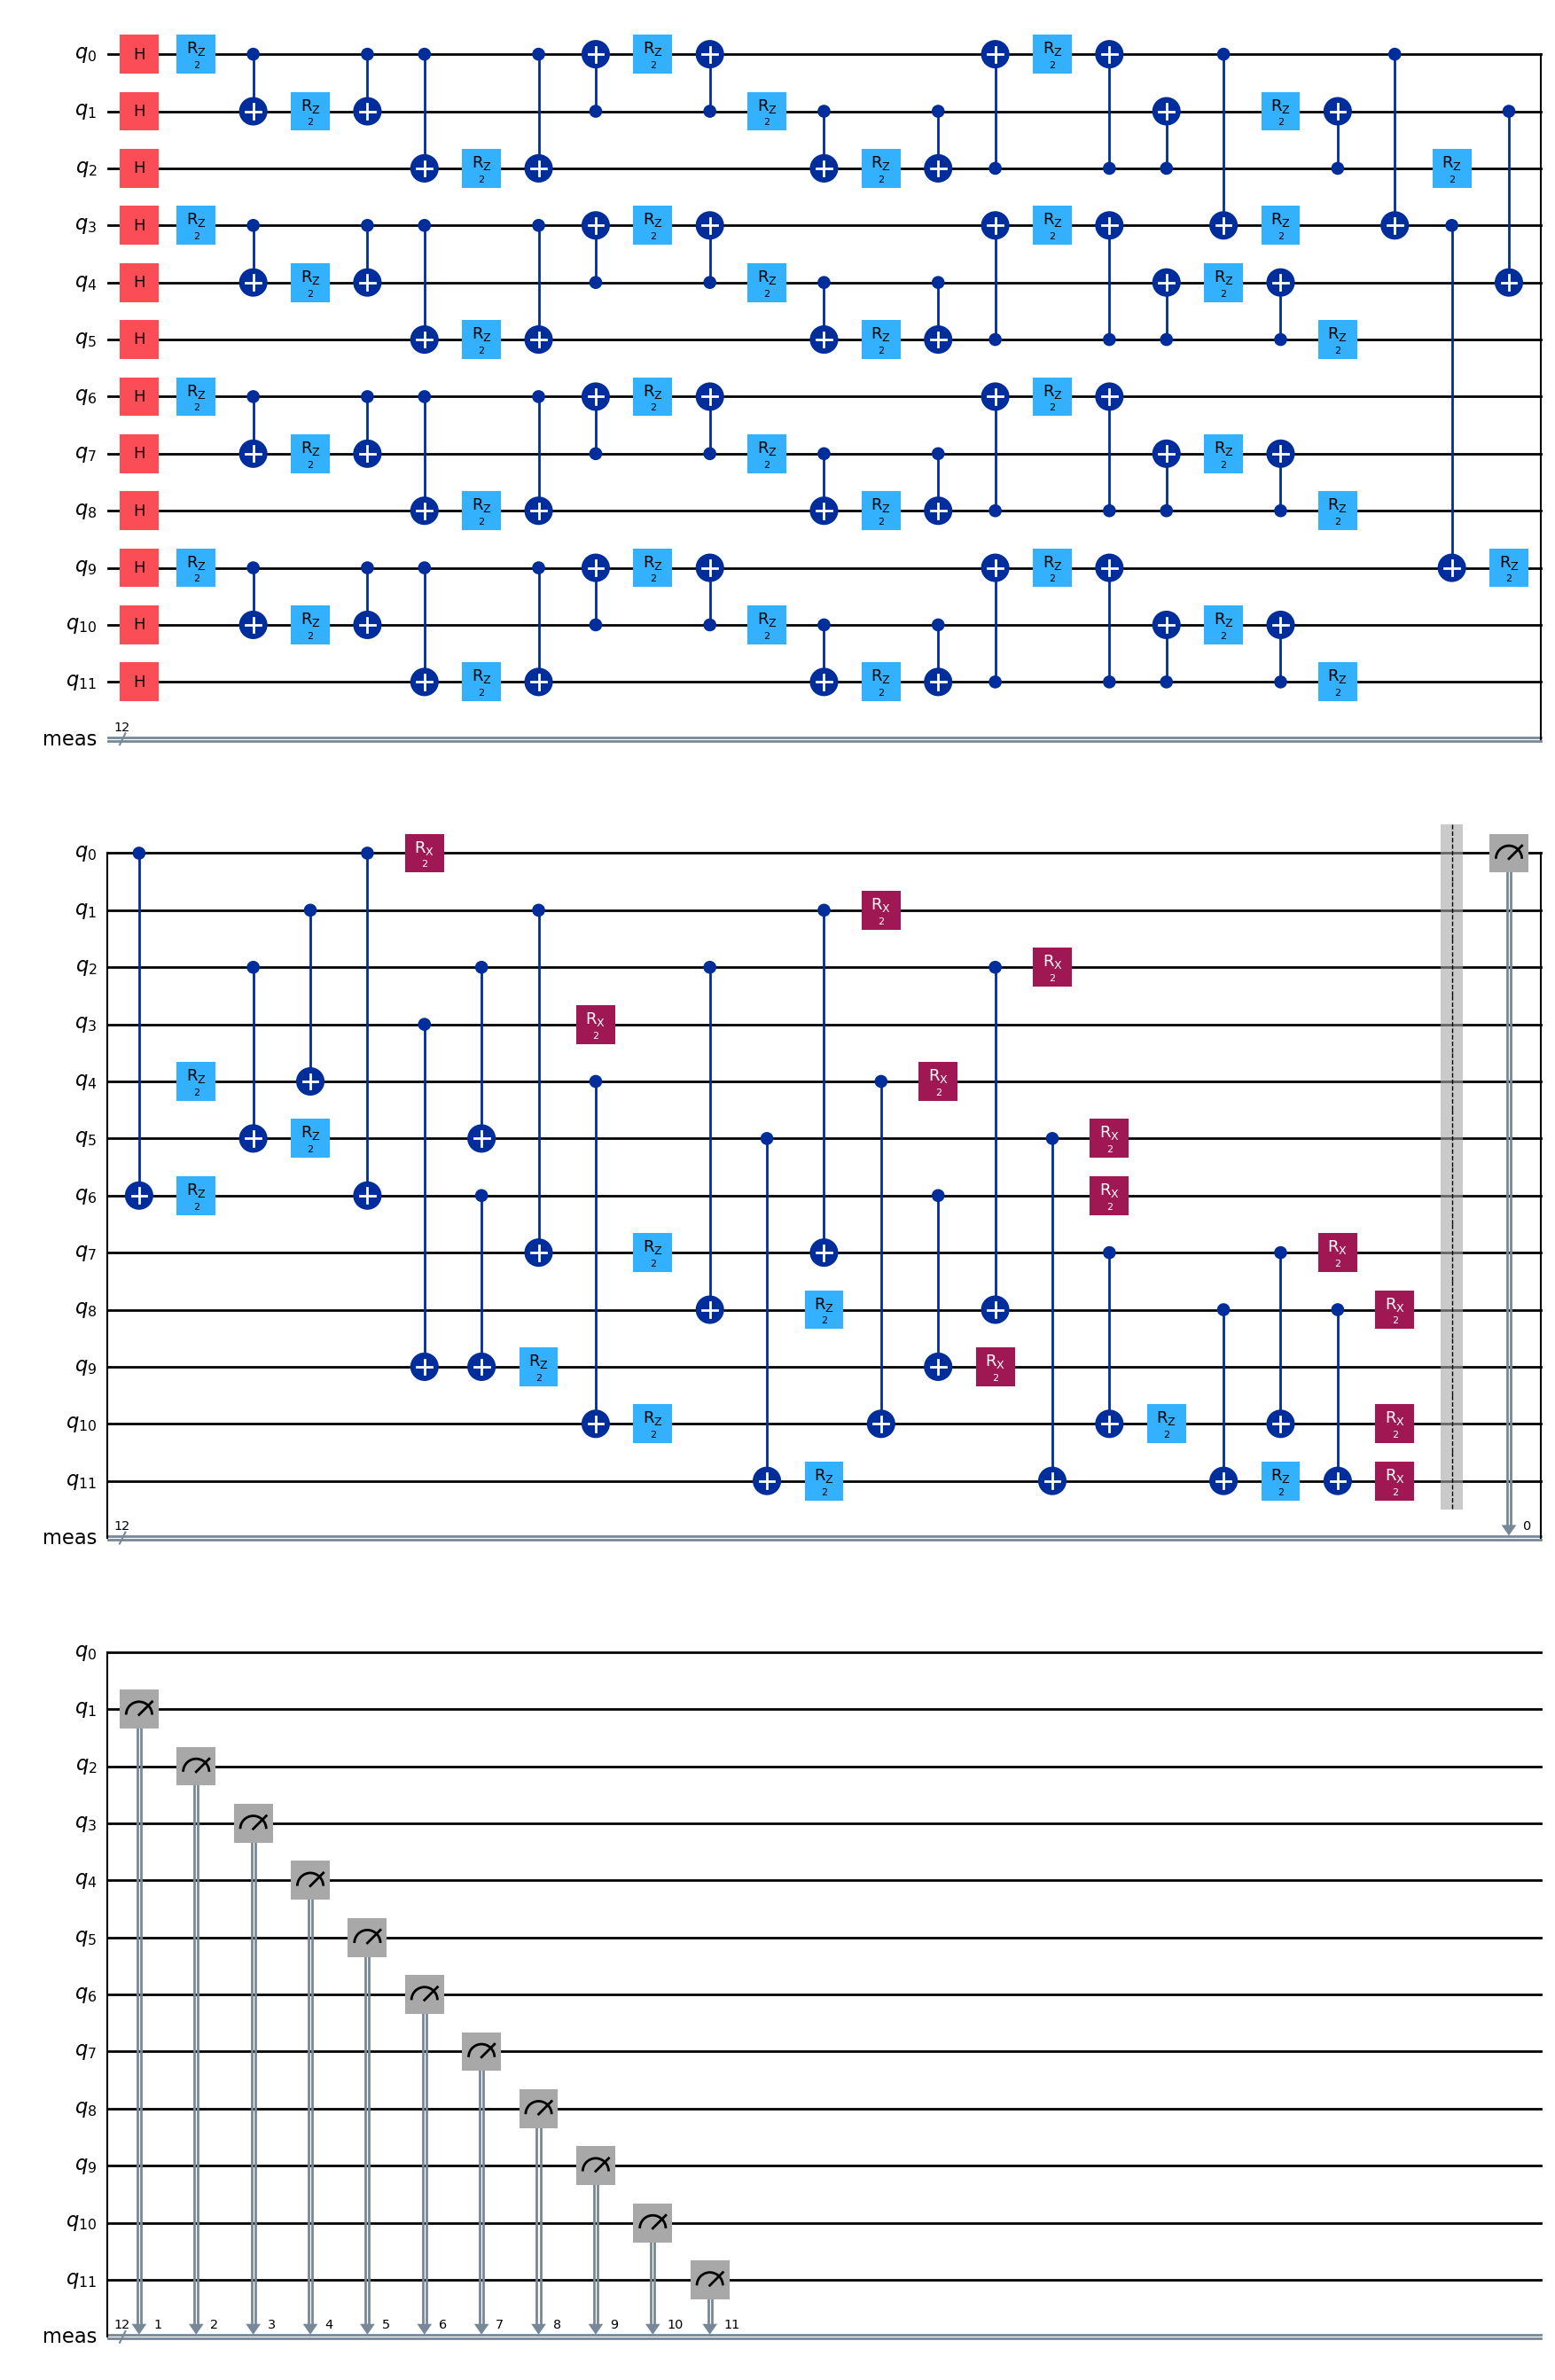

In [8]:
n_qubits = 4
n_colors = 3
qubits_total = n_qubits * n_colors
C = 1
D =1
edges = [(1,2), (1,3), (2,4), (3,4)]
gamma = 1
beta =1
qc3 = QuantumCircuit(qubits_total)
initial_state_preparation(qc3, n_qubits, n_colors)
one_color(qc3, n_qubits, n_colors, C, gamma)
vertex_color(qc3, n_colors, edges, gamma, D )
mix_layer(qc3, n_qubits, n_colors, beta)
qc3.measure_all()
qc3.draw('mpl')

In [9]:
service = QiskitRuntimeService(channel="ibm_quantum", token="caee5de19d31f203641647b0f5f2d97db528a62f5663ea3aee553ca111f454f1e4ed8c1b6c38e92a1355906e480e5bd88297912e7cf8be8964d19cb6976110fb") #add your IBMQ token here.

def create_cirq(n_qubits, n_colors, edges, C, D, depth, params):
    gammas = [j for i, j in enumerate(params) if i % 2 == 0]
    betas = [j for i, j in enumerate(params) if i % 2 == 1]
    qubits_total = n_qubits * n_colors
    qc3 = QuantumCircuit(qubits_total)
    initial_state_preparation(qc3, n_qubits, n_colors)
    for i in range(depth):
        one_color(qc3, n_qubits, n_colors, C,  gammas[i])
        vertex_color(qc3, n_colors, edges,  gammas[i], D )
        mix_layer(qc3, n_qubits, n_colors, betas[i])
    qc3.measure_all()
    
    backend = Aer.get_backend('qasm_simulator')
    pm = generate_preset_pass_manager(backend=backend, optimization_level=0)
    isa_circuit = pm.run(qc3)
    sampler = Sampler(mode=backend)
    job = sampler.run([(isa_circuit,)], shots=1024)
    job_result = job.result()
    pub_result = job.result()[0]
    counts = pub_result.data.meas.get_counts()
    return  counts

In [10]:
def cost_function( params):    
    counts = create_cirq(n_qubits, n_colors, edges, C, D, depth, params)
    total_cost = 0
    # Iterate over each bit string in the counts dictionary
    nn=0
    for bit_string, count in counts.items():
        
        cost = 0
        # First term: ensure exactly one color per vertex
        for v in range(n_qubits):
            color_bits = bit_string[v*3:(v+1)*3]  # Extract bits for vertex v
            sum_x_vc = sum(int(bit) for bit in color_bits)  # Sum colors for vertex v
            cost += C * (1 - sum_x_vc) ** 2
            
        # Second term: no two adjacent vertices share the same color
        for (u, v) in edges:
            for c in range(3):
                # Extract color bits for vertices u and v
                x_uc = int(bit_string[u*3 + c])
                x_vc = int(bit_string[v*3 + c])
                cost += D * x_uc * x_vc #all weights are 1
        
        # Weight the cost by the number of occurrences of the bit string
        total_cost += cost * count
        # nn=nn+1
        # print(bit_string)
        # print(total_cost)
        # print(nn)
        
    return -total_cost

In [11]:
from scipy.optimize import minimize
from qiskit_aer import Aer

n_qubits = 4
n_colors = 3
C = -1
D = 1
edges = [(0,1), (0,2), (1,3), (2,3)]
gamma = 1
beta = 1
depth =1 #p-value
params = np.random.uniform(-np.pi, np.pi, 2 * depth)

optimal_params = None
optimal_val = np.inf
out = minimize(cost_function, x0=params, method='COBYLA', options={'maxiter':200, 'disp':True})
print(out['fun'])
if out['fun'] < optimal_val:
    optimal_params = out['x']
    optimal_val = out['fun']

-1122.0
   Normal return from subroutine COBYLA

   NFVALS =   31   F =-1.122000E+03    MAXCV = 0.000000E+00
   X =-3.004680E+00  -1.205603E+00



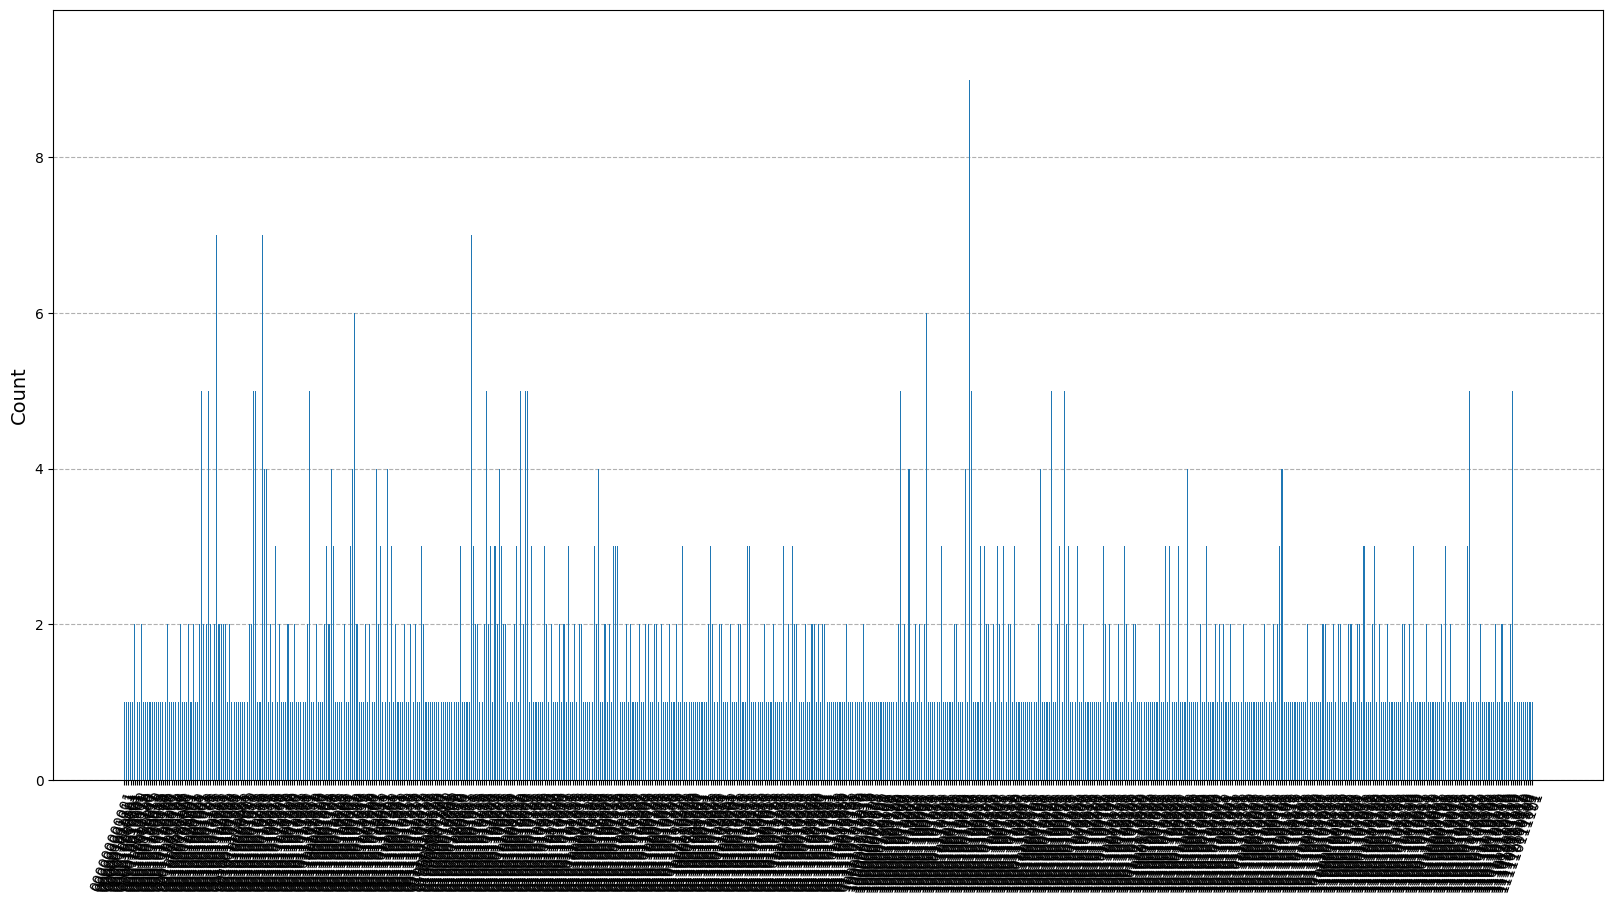

In [12]:
figsize = (20,10)
f = create_cirq(n_qubits, n_colors, edges, C, D, depth, optimal_params)
visualization.plot_histogram(f, figsize=figsize, bar_labels=False, legend=None)

In [13]:
# Extract the histogram data (assuming f is a dictionary where keys are the outcomes and values are their frequencies)
hist_data = f

# Find the maximum value and the corresponding key
max_value = max(hist_data.values())
max_key = max(hist_data, key=hist_data.get)

print(f"The highest value is {max_value}, corresponding to the outcome {max_key}.")


The highest value is 9, corresponding to the outcome 100010010100.


In [14]:
# Extract the histogram data (assuming f is a dictionary where keys are the outcomes and values are their frequencies)
hist_data = f

# Iterate through the dictionary and print all key-value pairs
for outcome, frequency in hist_data.items():
    print(f"Outcome: {outcome}, Frequency: {frequency}")


Outcome: 101010001010, Frequency: 2
Outcome: 011001010011, Frequency: 2
Outcome: 001001101011, Frequency: 1
Outcome: 100100001100, Frequency: 4
Outcome: 011001001100, Frequency: 2
Outcome: 001001100001, Frequency: 2
Outcome: 100100000100, Frequency: 2
Outcome: 001001010010, Frequency: 2
Outcome: 110110110110, Frequency: 5
Outcome: 001010010011, Frequency: 4
Outcome: 010101100010, Frequency: 2
Outcome: 001101100001, Frequency: 4
Outcome: 100001010100, Frequency: 2
Outcome: 001101101011, Frequency: 2
Outcome: 000001100001, Frequency: 2
Outcome: 001101001101, Frequency: 4
Outcome: 100010010011, Frequency: 1
Outcome: 010011110011, Frequency: 1
Outcome: 100001001001, Frequency: 5
Outcome: 101010100001, Frequency: 1
Outcome: 100010010000, Frequency: 1
Outcome: 010000001001, Frequency: 1
Outcome: 010011001010, Frequency: 2
Outcome: 100101000011, Frequency: 1
Outcome: 110111101111, Frequency: 1
Outcome: 011011001101, Frequency: 1
Outcome: 011100001110, Frequency: 2
Outcome: 100101011100, Frequ

In [15]:
# Extract the histogram data (assuming f is a dictionary where keys are the outcomes and values are their frequencies)
hist_data = f

# Sort the histogram by frequency in descending order
sorted_hist_data = sorted(hist_data.items(), key=lambda x: x[1], reverse=True)

# Print the sorted results
for outcome, frequency in sorted_hist_data:
    print(f"Outcome: {outcome}, Frequency: {frequency}")


Outcome: 100010010100, Frequency: 9
Outcome: 001001010001, Frequency: 7
Outcome: 001010010001, Frequency: 7
Outcome: 010001001001, Frequency: 7
Outcome: 100001100100, Frequency: 6
Outcome: 001100100100, Frequency: 6
Outcome: 110110110110, Frequency: 5
Outcome: 100001001001, Frequency: 5
Outcome: 100100010100, Frequency: 5
Outcome: 010010010001, Frequency: 5
Outcome: 001010001010, Frequency: 5
Outcome: 001010001011, Frequency: 5
Outcome: 100010010110, Frequency: 5
Outcome: 001001001001, Frequency: 5
Outcome: 001011011011, Frequency: 5
Outcome: 001001001100, Frequency: 5
Outcome: 010010001010, Frequency: 5
Outcome: 110100100100, Frequency: 5
Outcome: 010001010010, Frequency: 5
Outcome: 100100100100, Frequency: 5
Outcome: 010010010010, Frequency: 5
Outcome: 100100001100, Frequency: 4
Outcome: 001010010011, Frequency: 4
Outcome: 001101100001, Frequency: 4
Outcome: 001101001101, Frequency: 4
Outcome: 100001010001, Frequency: 4
Outcome: 001010010010, Frequency: 4
Outcome: 100010010010, Frequ